# Artigo 1
* Aluno: Paulo Henrique Costa Gontijo
* Matrícula: 15/0143800
* Lição: *Is it a bird?*

| Hitórico de versão | Data |
|:--------------------:|:------:|
| v1 | 02/11/2022 |

## Propósito
Este artigo tem a intenção de documentar o passo a passo da primeira lição do curso, mostrando os blocos códigos, o resultado das execuções, eventuais problemas encontrados e, se houverem, as possíveis soluções para os problemas.

## Tema
A lição perpassa pelos pontos fundamentais ao se desenvolver um modelo, desde a obtenção de dados via APIs, treinamento e validação.

## Instalação de bibliotecas
* Fastai
* DuckDuckGo

In [1]:
!pip install fastai duckduckgo_search matplotlib

  Using cached fastai-2.7.10-py3-none-any.whl (240 kB)
  Using cached matplotlib-3.6.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Using cached fastdownload-0.0.7-py3-none-any.whl (12 kB)
  Using cached torch-1.13.0-cp38-cp38-manylinux1_x86_64.whl (890.2 MB)
  Using cached Pillow-9.3.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Using cached spacy-3.4.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.6 MB)
  Using cached scipy-1.9.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (33.8 MB)
  Using cached pandas-1.5.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
  Using cached fastprogress-1.0.3-py3-none-any.whl (12 kB)
  Using cached fastcore-1.5.27-py3-none-any.whl (67 kB)
  Using cached scikit_learn-1.1.3-cp38-

> A lição original adiciona os parâmetros **-Uqq**, na execução, para fazer a instalação da versão mais recente das bibliotecas. Em minha experiência, obtive erros de compatibilidade com algumas bibliotecas (ex. flask), por isso optei por omitir o parâmetro, o que transfere a responsabilidade da compatibilidade para o gerenciador de pacotes **pip**.  

## Passo 1: Download das imagens
Usando a biblioteca duckduckgo, vamos buscar imagens de **carros** e **bicicletas** para desenvolver a lição.


In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### 1.1. Iniciaremos com o download das imagens de carros:

In [3]:
urls_cars = search_images('car photos', max_images=1)
urls_cars[0]

Searching for 'car photos'


'https://wallup.net/wp-content/uploads/2016/03/12/326278-Super_Car-city-yellow-blue-sky-clouds-vehicle-car-yellow_cars-McLaren.jpg'

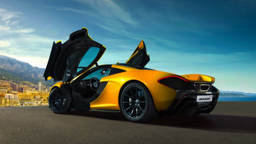

In [4]:
from fastdownload import download_url
dest = 'car.jpg'
download_url(urls_cars[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

### 1.2. Agora faremos o download de imagens de bicicletas:

Searching for 'bicycle photos'


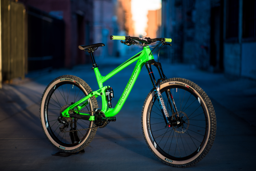

In [5]:
urls_bicycles = search_images('bicycle photos', max_images=1)
download_url(urls_bicycles[0], 'bicycle.jpg', show_progress=False)
Image.open('bicycle.jpg').to_thumb(256,256)

Uma vez validadas as buscas, ou seja, as imagens obtidas estão condizentes com a nossa expectativa, vamos agora buscar por um número maior de imagens para compor nossa base. 

### 1.3. Carregamento da base de dados 
Vamos separar por grupos e adicionar algumas condições nas fotos para ajudar na variação das ocorrências:

In [6]:
searches = 'car', 'bicycle'
path = Path('car_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'car photo'
Searching for 'car sun photo'
Searching for 'car shade photo'
Searching for 'bicycle photo'
Searching for 'bicycle sun photo'
Searching for 'bicycle shade photo'


## Passo 2: Tratamento da base de dados
Alguns downloads podem trazer conteúdos indesejados para nosso container de imagens. Para sanar este problema, utilizaremos a função **verify_images** para verificar e remover, previamente, se algum arquivo está corrompido e não poderá ser aberto.

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)
print(failed)

[Path('car_or_not/bicycle/9af7258e-d843-4ebb-b57f-566b54c00761.jpg'), Path('car_or_not/bicycle/7a021491-f890-4365-bab8-8c7f129252ac.jpg'), Path('car_or_not/car/08f738c8-08e0-44f6-8790-ddb9ff2177ca.jpg'), Path('car_or_not/car/15cb0651-6147-4691-a000-0fcd5157a6a3.jpeg'), Path('car_or_not/car/a135bc4f-514d-4f98-be47-bdb30402b11f.jpg'), Path('car_or_not/car/288e9e9a-931e-4f78-911a-eefda514ba9a.jpg'), Path('car_or_not/car/d1246adf-9227-4174-b7ef-161c4015d164.jpg')]


## Passo 3: Treinamento do modelo
## 3.1. Criação de um DataBlock
Para treinar o modelo, necessitamos utilizar o **DataLoaders** como módulo de carregamento dos dados. Ele será responsável por colocar em *cache* os datasets de treinamento e validação. 

A maneira de se comunicar com os DataLoaders é por meio da criação de um **DataBlock**.

Para criar um DataBlock é necessário colocar quatro parâmetros: os tipos de *inputs* e *labels* dos mesmos e, pelo as funções `get_items` e `splitter`, responsáveis por entregar o *path* dos arquivos e dividir as bases de treinamento e validação, respectivamente. Você pode necessitar de incluir os parâmetros `get_x` e/ou `get_y` caso necessário customizar as labels de categoria. 


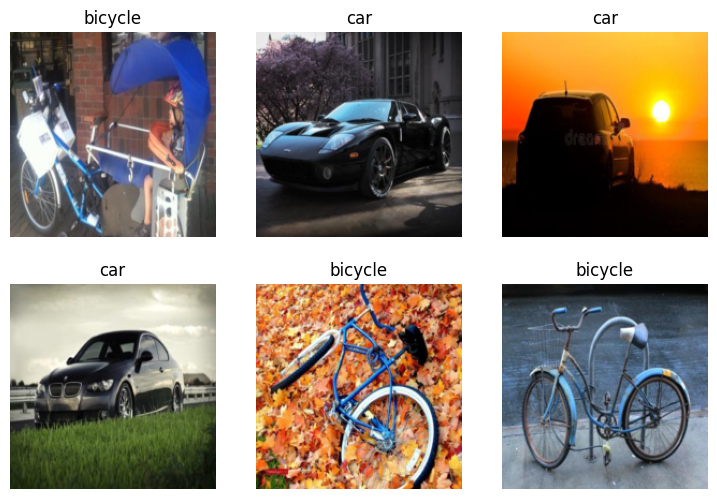

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

## 3.2. Execução do treinamento
No exemplo abaixo foi utilizado um modelo pré-treinado chamado **resnet18**. 
Utilizaremos a função `fine_tune` da biblioteca **Fastai** a fim de ajustar tal modelo à nossa realidade.

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/home/paulo/Documents/Unb/mlops/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paulo/Documents/Unb/mlops/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/paulo/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

* Erros encontrados neste processo, mas não impediram a execução:

> /usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed
> in 0.15, please use 'weights' instead.
> f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "

> /usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated
> since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `
> weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
> warnings.warn(msg)

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

This is a: car.
Probability it's a bicyle: 0.0008


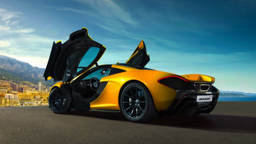

In [10]:
img = 'car.jpg'
is_what,_,probs = learn.predict(PILImage.create(img))
print(f"This is a: {is_what}.")
print(f"Probability it's a bicyle: {probs[0]:.4f}")

im = Image.open(img)
im.to_thumb(256,256)

This is a: bicycle.
Probability it's a bicyle: 0.9999


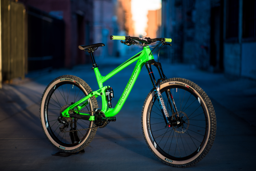

In [11]:
img = 'bicycle.jpg'
is_what,_,probs = learn.predict(PILImage.create(img))
print(f"This is a: {is_what}.")
print(f"Probability it's a bicyle: {probs[0]:.4f}")

im = Image.open(img)
im.to_thumb(256,256)

## Referências bibliográficas

> https://course.fast.ai/, acessado em 02/11/2022

> https://course.fast.ai/Lessons/lesson1.html, acessado em 02/11/2022

> https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data, acessado em 02/11/2022

> https://docs.fast.ai/data.block.html, acessado em 02/11/2022